## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
import seaborn as sns
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Load Data

In [3]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
category             200853 non-null object
headline             200853 non-null object
authors              200853 non-null object
link                 200853 non-null object
short_description    200853 non-null object
date                 200853 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [5]:
df.shape

(200853, 6)

In [6]:
# Size by category
categories = df.groupby('category')
print("total categories:", categories.ngroups)
print(categories.size().head())

total categories: 41
category
ARTS              1509
ARTS & CULTURE    1339
BLACK VOICES      4528
BUSINESS          5937
COLLEGE           1144
dtype: int64


## Data Wrangling

In [7]:
# THE WORLDPOST and WORLDPOST should be the same category, so change 'THE WORLDPOST' to 'WORLDPOST'.
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [8]:
# Display number of articles, authors and categories
print("Total number of articles : ", df.shape[0])
print("Total number of authors : ", df["authors"].nunique())
print("Total number of unqiue categories : ", df["category"].nunique())

Total number of articles :  200853
Total number of authors :  27993
Total number of unqiue categories :  40


In [9]:
# Size by category
categories = df.groupby('category')
print("total categories:", categories.ngroups)
print(categories.size().head())

total categories: 40
category
ARTS              1509
ARTS & CULTURE    1339
BLACK VOICES      4528
BUSINESS          5937
COLLEGE           1144
dtype: int64


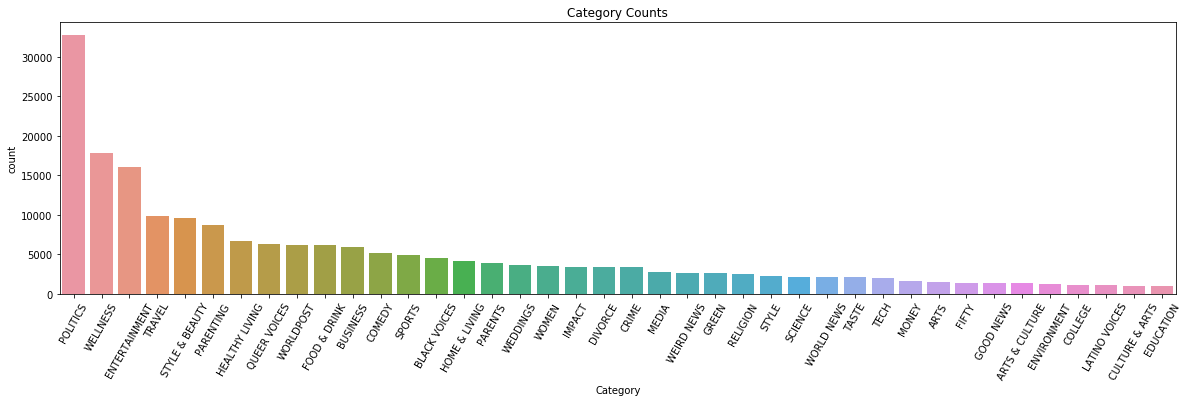

In [10]:
# Plot by category
figure, ax = plt.subplots(1, 1, figsize = (20, 5))

ax = sns.countplot(df['category'],order=df['category'].value_counts().index)
ax.set_title("Category Counts")
ax.set_xlabel("Category")
# Manipulate the labels to make them more readable
ax.set_xticklabels([x for x in ax.get_xticklabels()], rotation=60)
plt.show()

### From the above plot we observe that politics, wellness and entertainment are the top 3 news article categories.

## Tokenizing

In [13]:
# Using headlines and short_description as input X
df['text'] = df.headline + " " + df.short_description

In [14]:
# Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

In [15]:
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [16]:
df.head()

,category,headline,authors,link,short_description,date,text,words,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26


In [17]:
df.shape

(199914, 9)

In [18]:
# check for null values
df.category.isnull().sum()

0

In [19]:
# view word length distribution
df.word_length.describe()

count    199914.000000
mean         29.725032
std          14.024717
min           5.000000
25%          20.000000
50%          29.000000
75%          36.000000
max         248.000000
Name: word_length, dtype: float64

(0, 130)

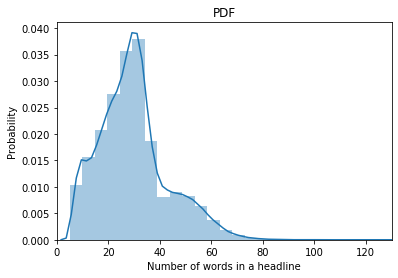

In [20]:
# PDF for the number of words in a headline
ax = sns.distplot(df.word_length)
ax.set_title('PDF')
ax.set_xlabel('Number of words in a headline')
ax.set_ylabel('Probability')
ax.set_xlim(0,130)

## pad_sequences
keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
Pads sequences to the same length.
This function transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.
Sequences that are shorter than num_timesteps are padded with value at the end.
Sequences longer than num_timesteps are truncated so that they fit the desired length. The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.
Pre-padding is the default.

In [21]:
# using 50 for padding length
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

In [22]:
# category to id
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

In [23]:
df.head()

,category,headline,authors,link,short_description,date,text,words,word_length,c2id
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27,6
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20,10
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25,10
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26,10
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26,10


A word embedding is an approach to provide a dense vector representation of words that capture something about their meaning.
Word embeddings are an improvement over simpler bag-of-word model word encoding schemes like word counts and frequencies that result in large and sparse vectors (mostly 0 values) that describe documents but not the meaning of the words.
Word embeddings work by using an algorithm to train a set of fixed-length dense and continuous-valued vectors based on a large corpus of text. Each word is represented by a point in the embedding space and these points are learned and moved around based on the words that surround the target word.
It is defining a word by the company that it keeps that allows the word embedding to learn something about the meaning of words. The vector space representation of the words provides a projection where words with similar meanings are locally clustered within the space.
The use of word embeddings over other text representations is one of the key methods that has led to breakthrough performance with deep neural networks on problems like machine translation.

## GloVe Embedding

Global Vectors for Word Representation:          
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
The smallest GloVe pre-trained model is from the GloVe website. It an 822 Megabyte zip file with 4 different models (50, 100, 200 and 300-dimensional vectors) trained on Wikipedia data with 6 billion tokens and a 400,000 word vocabulary.

In [24]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('No. of unique tokens: ', len(word_index))
print('Total No. of word vectors: ', len(embeddings_index))

No. of unique tokens:  116617
Total No. of word vectors:  400000


In [25]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## Split Train and Test data

In [26]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

## Convulution Neural Network (CNN) - GloVe embedding
Traditionally CNN is popular is for identifying objects inside images. It can also be extended for text classification with the help of word embeddings. CNN has been found effective for text in search query retrieval, sentence modelling and other traditional NLP (Natural Language Processing) tasks.
Once an image is converted to vectorized representation or text is converted to embedding, it looks similar to machine as shown in picture below. In case of image each cell in the represents raw intensity of specific channel whereas in case of text, each row of table represents a word.
Just like in traditional CNN, lower level layers helps in identifying edges, parts of bigger objects and successive layers identifies objects, in case of text classification, lower layer tried to find association between words where as higher layer tries to find association between group of words. These groups can be sentences, paragraphs or smaller subgroups.

A typical convolution layer network architecture has multiple layers.
CNN is supervised ML algorithm. The training set is first converted to word embeddings using glove embeddings. We first pass it through a series of convolution and pooling layer to extract lower levels features first and then learn higher level features from lower level features.

In our training first we split input dataset into 80% training and 20% validation set. We feed input dataset for training to CNN. we are going to apply 64 such filters on training dataset. Each filter will be applied to 2,3,4 words at a time. After convolution the output is passed through RELU activation layer to remove negative samples and keep only positive samples. Output of RELU is passed through max pooling layer to retain most important information.

We then pass the output through a dropout layer to prevent overfitting. We then pass it through another set fo 1D convolution, RELU and max pooling.

Finally the last layer in CNN is typically feed forward neural network that learns to map the pooling function output to output categories in terms of softmax probabilities.

Now that our network architecture is up, we train the model for 20 epochs and measure its performance over validation set.

In [27]:
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      11661800    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       12864       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 64)       19264       embedding_1[0][0]                
____________________________________________________________________________________________

In [28]:
textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=20, 
                              validation_data=(x_val, y_val))

Train on 159931 samples, validate on 39983 samples
Epoch 1/20
159931/159931 [==============================] - 60s 376us/step - loss: 2.2437 - accuracy: 0.4143 - val_loss: 1.7278 - val_accuracy: 0.5349
Epoch 2/20
159931/159931 [==============================] - 61s 380us/step - loss: 1.8735 - accuracy: 0.4960 - val_loss: 1.6305 - val_accuracy: 0.5575
Epoch 3/20
159931/159931 [==============================] - 66s 412us/step - loss: 1.8034 - accuracy: 0.5140 - val_loss: 1.5914 - val_accuracy: 0.5666
Epoch 4/20
159931/159931 [==============================] - 66s 411us/step - loss: 1.7644 - accuracy: 0.5222 - val_loss: 1.5690 - val_accuracy: 0.5701
Epoch 5/20
159931/159931 [==============================] - 65s 404us/step - loss: 1.7399 - accuracy: 0.5304 - val_loss: 1.5513 - val_accuracy: 0.5712
Epoch 6/20
159931/159931 [==============================] - 66s 411us/step - loss: 1.7235 - accuracy: 0.5334 - val_loss: 1.5455 - val_accuracy: 0.5756
Epoch 7/20
159931/159931 [=================

In [121]:
data_metrics = []
score = TextCNN.evaluate(x_val, y_val,
                       batch_size=batch_size, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
data_metrics.append(['CNN with GloVe embedding',score[0],score[1]])

39983/39983 [==============================] - 4s 109us/step
Validation loss: 1.4993746934662053
Validation accuracy: 0.5915763974189758


In [78]:
textcnn_history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [95]:
# define function to plot model metrics
def plot_model_metrics(h, t):
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy - '+t)
    plt.plot(epochs, acc, 'red', label='Training acc', color='b')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc', color='g')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss - '+t)
    plt.plot(epochs, loss, 'red', label='Training loss', color='b')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss', color='g')
    plt.legend()

    plt.show()

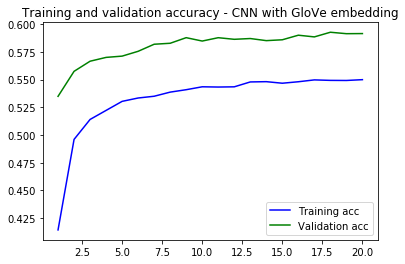

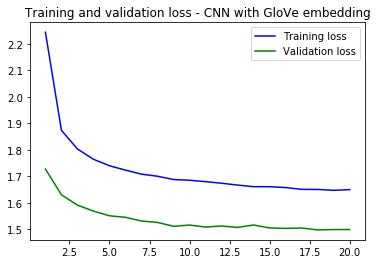

In [122]:
plot_model_metrics(textcnn_history,'CNN with GloVe embedding')

## Recurrent Neural Network (RNN) - Long Short Term Memory (LSTM) using Keras 
## - without Embedding
Vectorize news headlines, by turning each text into either a sequence of integers or into a vector.
Limit the data set to the top 1000 words.
The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 512 memory units.
The output layer must create 40 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [84]:
# deep learning model without embedding 
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['text'][:train_size]
train_tags = df['category'][:train_size]

test_posts = df['text'][train_size:]
test_tags = df['category'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history_lstm = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))



Train on 139939 samples, validate on 59975 samples
Epoch 1/20
139939/139939 [==============================] - 37s 261us/step - loss: 2.1755 - accuracy: 0.4214 - val_loss: 2.4879 - val_accuracy: 0.3247
Epoch 2/20
139939/139939 [==============================] - 33s 236us/step - loss: 1.9238 - accuracy: 0.4705 - val_loss: 2.5525 - val_accuracy: 0.3165
Epoch 3/20
139939/139939 [==============================] - 32s 227us/step - loss: 1.8364 - accuracy: 0.4882 - val_loss: 2.5835 - val_accuracy: 0.3250
Epoch 4/20
139939/139939 [==============================] - 32s 227us/step - loss: 1.7596 - accuracy: 0.5047 - val_loss: 2.6121 - val_accuracy: 0.3385
Epoch 5/20
139939/139939 [==============================] - 32s 228us/step - loss: 1.6965 - accuracy: 0.5190 - val_loss: 2.6425 - val_accuracy: 0.3328
Epoch 6/20
139939/139939 [==============================] - 33s 233us/step - loss: 1.6344 - accuracy: 0.5323 - val_loss: 2.7279 - val_accuracy: 0.3217
Epoch 7/20
139939/139939 [=================

In [126]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Validation Loss:',score[0])
print('Validation accuracy:', score[1])
data_metrics.append(['LSTM without embedding',score[0],score[1]])

59975/59975 [==============================] - 3s 48us/step
Validation Loss: 3.9045065682964952
Validation accuracy: 0.31256356835365295


In [102]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               512512    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 40)                20520     
_________________________________________________________________
activation_8 (Activation)    (None, 40)                0         
Total params: 533,032
Trainable params: 533,032
Non-trainable params: 0
_________________________________________________________________


In [86]:
history_lstm.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

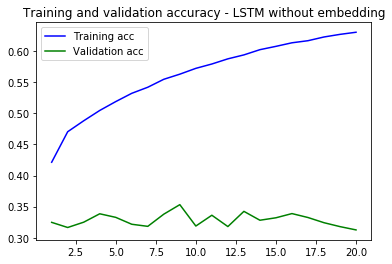

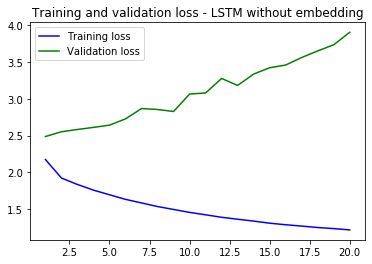

In [109]:
plot_model_metrics(history_lstm,'LSTM without embedding')

In [88]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(139939, 1000) (139939, 40)
(59975, 1000) (59975, 40)


## Recurrent Neural Network (RNN) - Long Short Term Memory (LSTM) architecture 
## - using Keras Embedding
Vectorize news headlines, by turning each text into either a sequence of integers or into a vector. Limit the data set to the top 1000 words. The first layer is the embedded layer that uses 100 length vectors to represent each word. SpatialDropout1D performs variational dropout in NLP models. The next layer is the LSTM layer with 100 memory units. The output layer must create 40 output values, one for each class. Activation function is softmax for multi-class classification. Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function. Keras inbuilt embedding is used here.

In [50]:
# LSTM model with keras embedding
model_e = Sequential()
model_e.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=maxlen))
model_e.add(SpatialDropout1D(0.2))
model_e.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_e.add(Dense(40, activation='softmax'))
model_e.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
model_e.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           11661800  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 40)                4040      
Total params: 11,746,240
Trainable params: 11,746,240
Non-trainable params: 0
_________________________________________________________________


In [51]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [52]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(159931, 50) (159931, 40)
(39983, 50) (39983, 40)


In [53]:
from keras.callbacks import EarlyStopping
epochs = 5
batch_size = 32
history = model_e.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_val, y_val)
                   ,callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159931 samples, validate on 39983 samples
Epoch 1/5
159931/159931 [==============================] - 1002s 6ms/step - loss: 2.0914 - accuracy: 0.4523 - val_loss: 1.4864 - val_accuracy: 0.5946
Epoch 2/5
159931/159931 [==============================] - 988s 6ms/step - loss: 1.2825 - accuracy: 0.6440 - val_loss: 1.2946 - val_accuracy: 0.6379
Epoch 3/5
159931/159931 [==============================] - 1002s 6ms/step - loss: 0.9772 - accuracy: 0.7170 - val_loss: 1.3137 - val_accuracy: 0.6382
Epoch 4/5
159931/159931 [==============================] - 1043s 7ms/step - loss: 0.7579 - accuracy: 0.7765 - val_loss: 1.4058 - val_accuracy: 0.6285
Epoch 5/5
159931/159931 [==============================] - 1056s 7ms/step - loss: 0.5984 - accuracy: 0.8234 - val_loss: 1.5391 - val_accuracy: 0.6205


In [127]:
score = model_e.evaluate(x_val, y_val,
                       batch_size=batch_size, verbose=1)
print('Validation Loss:', score[0])
print('Validation Accuracy:', score[1])
data_metrics.append(['LSTM with keras embedding',score[0],score[1]])

39983/39983 [==============================] - 13s 335us/step
Validation Loss: 1.5391094215074308
Validation Accuracy: 0.620488703250885


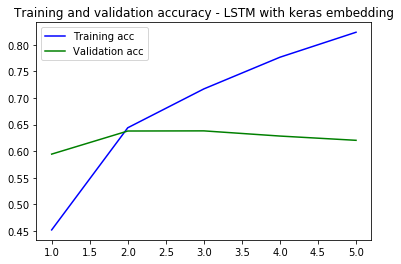

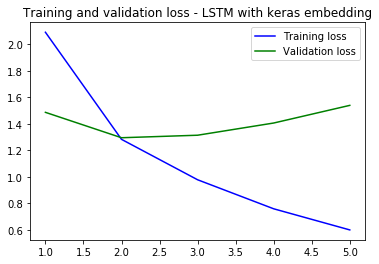

In [98]:
plot_model_metrics(history,'LSTM with keras embedding')

## LSTM architecture
## - with gensim Word2Vec
Word2vec, like doc2vec, belongs to the text preprocessing phase. Specifically, to the part that transforms a text into a row of numbers. Word2vec is a type of mapping that allows words with similar meaning to have similar vector representation.
The idea behind Word2vec is rather simple: we want to use the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation.
First we load a word2vec model. It has been pre-trained by Google on a 100 billion word Google News corpus.
Google’s pre-trained model(1.5GB!) includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features. Gensim allocates a big matrix to hold all of the word vectors.

In [36]:
import gensim
# Load Google's pre-trained Word2Vec model.
model_gen = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [58]:
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our TensorFlow and Keras models
embedding_matrix_gen = np.zeros((len(word_index) + 1, 300))
#embedding_matrix_gen = np.zeros((len(model_gen.wv.vocab), 300))
for word, i in word_index.items():
    if word in model_gen.vocab:
        embedding_matrix_gen[i] = model_gen.word_vec(word)

In [59]:
embeddings_gen = Embedding(input_dim=len(word_index) + 1, output_dim=300,
                      weights=[embedding_matrix_gen], input_length=maxlen,
                            trainable=False)

In [60]:
# LSTM model with gensim embedding
model_g = Sequential()
model_g.add(embeddings_gen)
model_g.add(SpatialDropout1D(0.2))
model_g.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_g.add(Dense(40, activation='softmax'))
model_g.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
model_g.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 300)           34985400  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_11 (Dense)             (None, 40)                4040      
Total params: 35,149,840
Trainable params: 164,440
Non-trainable params: 34,985,400
_________________________________________________________________


In [61]:
history_g = model_g.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_val, y_val)
                   ,callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 159931 samples, validate on 39983 samples
Epoch 1/5
159931/159931 [==============================] - 349s 2ms/step - loss: 1.8888 - accuracy: 0.4904 - val_loss: 1.4485 - val_accuracy: 0.5876
Epoch 2/5
159931/159931 [==============================] - 553s 3ms/step - loss: 1.4914 - accuracy: 0.5773 - val_loss: 1.3502 - val_accuracy: 0.6102
Epoch 3/5
159931/159931 [==============================] - 350s 2ms/step - loss: 1.4004 - accuracy: 0.5978 - val_loss: 1.3109 - val_accuracy: 0.6194
Epoch 4/5
159931/159931 [==============================] - 352s 2ms/step - loss: 1.3456 - accuracy: 0.6105 - val_loss: 1.2727 - val_accuracy: 0.6301
Epoch 5/5
159931/159931 [==============================] - 332s 2ms/step - loss: 1.3119 - accuracy: 0.6174 - val_loss: 1.2571 - val_accuracy: 0.6331


In [128]:
score = model_g.evaluate(x_val, y_val,
                       batch_size=batch_size, verbose=1)
print('Validation loss:',score[0])
print('Validation accuracy:', score[1])
data_metrics.append(['LSTM with gensim Word2Vec embedding',score[0],score[1]])

39983/39983 [==============================] - 24s 596us/step
Validation loss: 1.2570988957271256
Validation accuracy: 0.6331190466880798


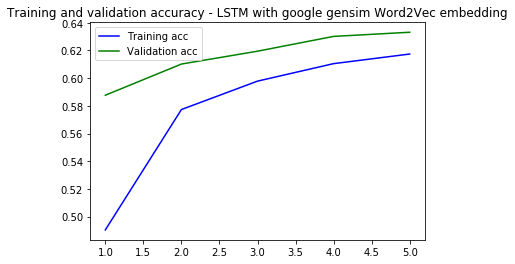

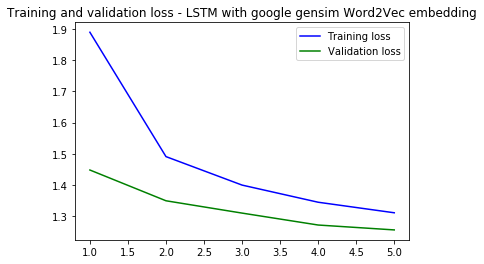

In [99]:
plot_model_metrics(history_g,'LSTM with google gensim Word2Vec embedding')

## Build neural network with LSTM and CNN 
## - with gensim Word2Vec embedding
The LSTM model worked well. However, it takes forever to train five epochs. One way to speed up the training time is to improve the network adding “Convolutional” layer. Convolutional Neural Networks (CNN) come from image processing. They pass a “filter” over the data and calculate a higher-level representation. They have been shown to work surprisingly well for text, even though they have none of the sequence processing ability of LSTMs.


In [71]:
# LSTM and CNN model with gensim embedding
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(embeddings_gen)
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model_conv.add(Dense(40, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv

In [72]:
model_conv = create_conv_model()

In [105]:
model_conv.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 300)           34985400  
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 64)            96064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_13 (Dense)             (None, 40)                4040      
Total params: 35,151,504
Trainable params: 166,104
Non-trainable params: 34,985,400
___________________________________

In [73]:
history_conv = model_conv.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_val, y_val)
                   )

Train on 159931 samples, validate on 39983 samples
Epoch 1/5
159931/159931 [==============================] - 170s 1ms/step - loss: 1.8655 - accuracy: 0.4983 - val_loss: 1.5155 - val_accuracy: 0.5748
Epoch 2/5
159931/159931 [==============================] - 162s 1ms/step - loss: 1.5725 - accuracy: 0.5619 - val_loss: 1.4306 - val_accuracy: 0.5960
Epoch 3/5
159931/159931 [==============================] - 154s 961us/step - loss: 1.4970 - accuracy: 0.5799 - val_loss: 1.3994 - val_accuracy: 0.6023
Epoch 4/5
159931/159931 [==============================] - 157s 980us/step - loss: 1.4551 - accuracy: 0.5883 - val_loss: 1.3890 - val_accuracy: 0.6028
Epoch 5/5
159931/159931 [==============================] - 158s 991us/step - loss: 1.4251 - accuracy: 0.5948 - val_loss: 1.3792 - val_accuracy: 0.6077


In [129]:
score = model_conv.evaluate(x_val, y_val,
                       batch_size=batch_size, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
data_metrics.append(['LSTM + CNN with gensim Word2Vec embedding',score[0],score[1]])

39983/39983 [==============================] - 8s 201us/step
Validation loss: 1.3792227489106357
Validation accuracy: 0.6077082753181458


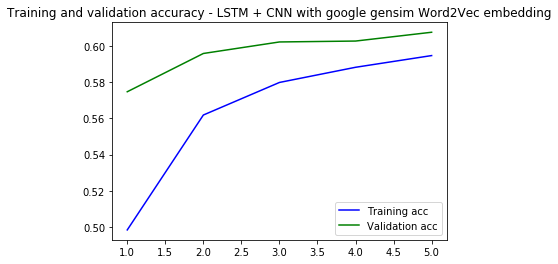

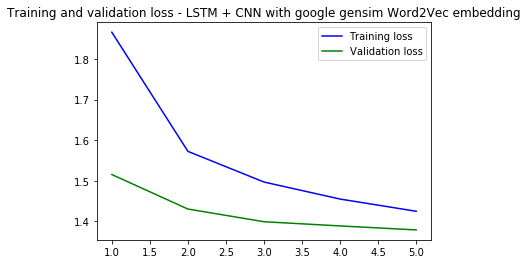

In [100]:
plot_model_metrics(history_conv,'LSTM + CNN with google gensim Word2Vec embedding')

## Create a dataframe with evaluation metrics from the various models above

In [130]:
metrics_df = pd.DataFrame(data_metrics, columns=['model','ValidationLoss','ValidationAccuracy'])

## Display model and metrics

In [131]:
metrics_df

,model,ValidationLoss,ValidationAccuracy
0,CNN with GloVe embedding,1.499375,0.591576
1,LSTM without embedding,3.904507,0.312564
2,LSTM with keras embedding,1.539109,0.620489
3,LSTM with gensim Word2Vec embedding,1.257099,0.633119
4,LSTM + CNN with gensim Word2Vec embedding,1.379223,0.607708


## Plot model and metrics

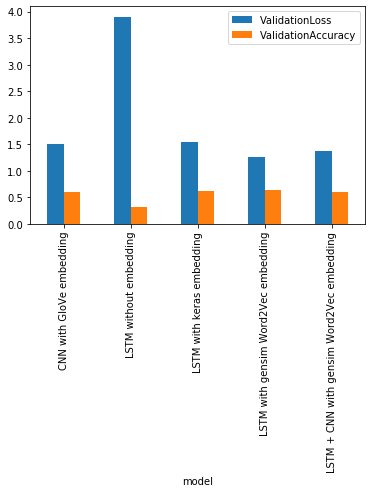

In [132]:
metrics_df.plot(kind='bar',x='model')

### Confusion Matrix - LSTM with gensim Word2Vec embedding
From the above data and plot we clearly see that LSTM model with gensim Word2Vec embedding has given the maximum accuracy and lowest loss compared to other implemented models. Lets take a look at the confusion matrix for the same.

In [63]:
y_pred = model_g.predict(x_val)

In [133]:
cm = pd.DataFrame(confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

In [136]:
from IPython.display import display
pd.options.display.max_columns = None
print('\nConfusion Matrix for LSTM with gensim Word2Vec embedding:')
display(cm)


Confusion Matrix for LSTM with gensim Word2Vec embedding:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,90,8,2,2,0,2,0,7,0,0,75,1,1,3,0,3,4,3,1,1,0,0,4,2,7,3,8,3,2,11,4,2,1,19,0,2,23,3,0,5
1,4,81,7,2,0,4,0,4,0,0,48,1,0,2,2,0,2,1,1,2,2,0,5,3,24,6,5,1,0,3,1,1,3,7,3,13,4,6,0,5
2,1,3,248,3,5,6,50,1,3,7,202,0,1,9,7,2,7,2,12,1,6,3,10,5,161,17,16,1,24,5,26,3,3,4,3,4,11,6,2,11
3,1,0,7,524,8,2,9,0,0,2,27,2,2,15,1,20,49,5,11,0,10,52,18,0,159,7,1,6,11,5,10,4,32,26,1,9,105,10,1,31
4,1,0,9,3,78,0,6,0,1,17,10,0,0,1,1,1,3,1,0,0,3,3,8,1,46,0,1,0,6,1,0,4,1,1,0,1,13,2,0,1
5,2,3,9,3,3,366,1,0,0,2,192,10,1,10,1,4,19,3,0,1,8,6,19,11,126,6,6,4,20,8,10,11,18,25,3,39,30,11,0,1
6,0,0,11,2,1,0,394,0,0,0,17,1,0,2,3,6,1,1,2,0,0,3,6,4,111,3,6,2,2,0,0,0,2,4,1,54,9,1,0,21
7,20,14,2,3,0,2,0,76,1,0,31,0,0,2,0,1,2,7,0,0,0,1,9,0,4,2,1,1,1,1,18,0,1,13,0,1,14,1,0,0
8,0,0,1,1,0,0,1,0,516,0,10,0,1,0,1,0,4,1,1,0,0,1,41,1,5,0,0,0,1,0,4,0,1,6,64,1,41,4,0,0
9,1,0,5,5,13,0,1,0,0,56,3,0,1,0,1,0,3,0,4,0,0,8,24,1,39,1,1,2,1,0,0,0,1,0,0,0,19,0,0,3


Text(159.0, 0.5, 'Predicted')

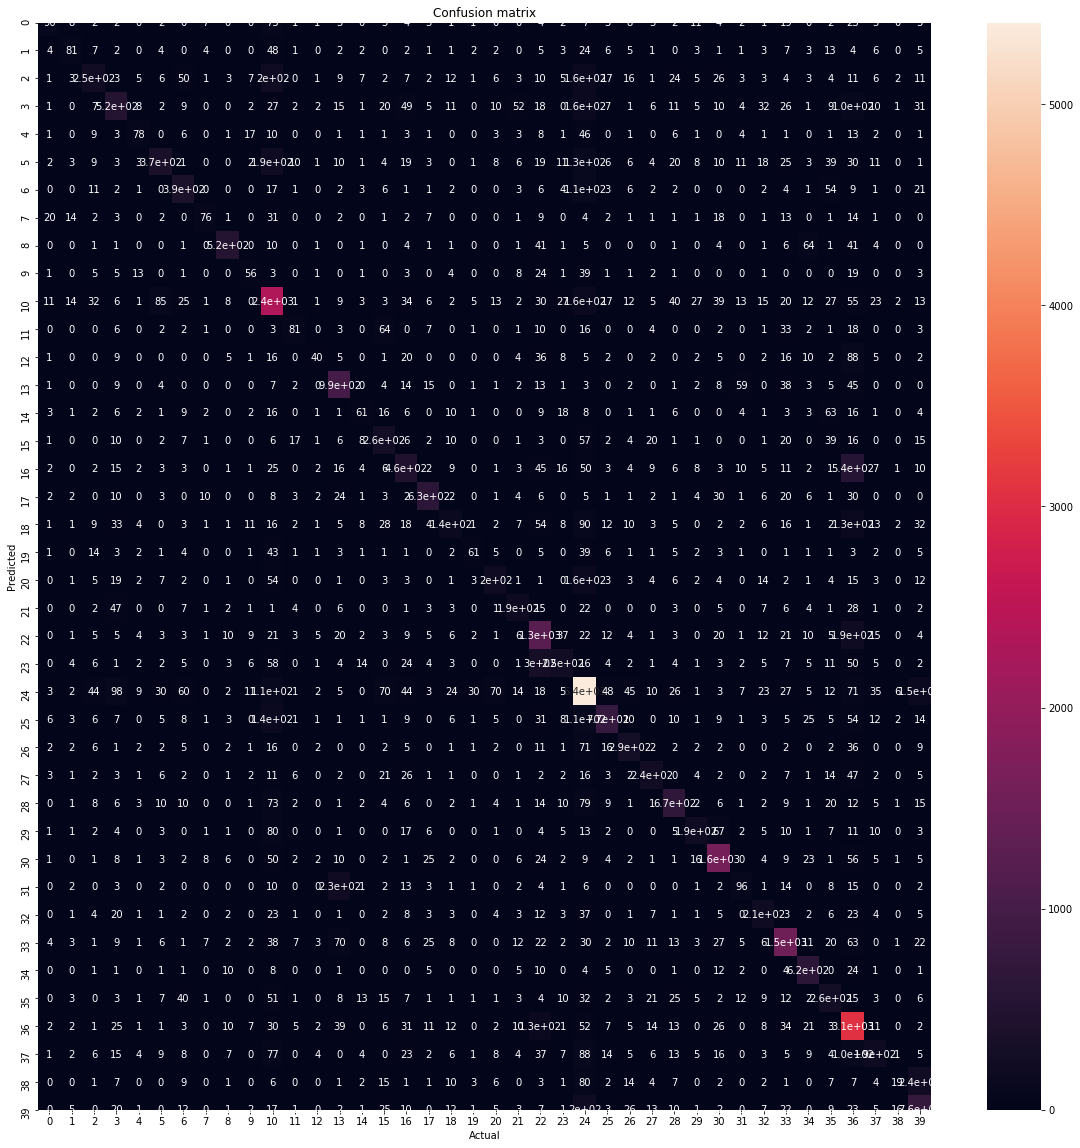

In [150]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion matrix')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

In [148]:
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn

def get_new_fig(fn, figsize=[20,20]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[20,20], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()

/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:149: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/Users/priyasathish/opt/anaconda

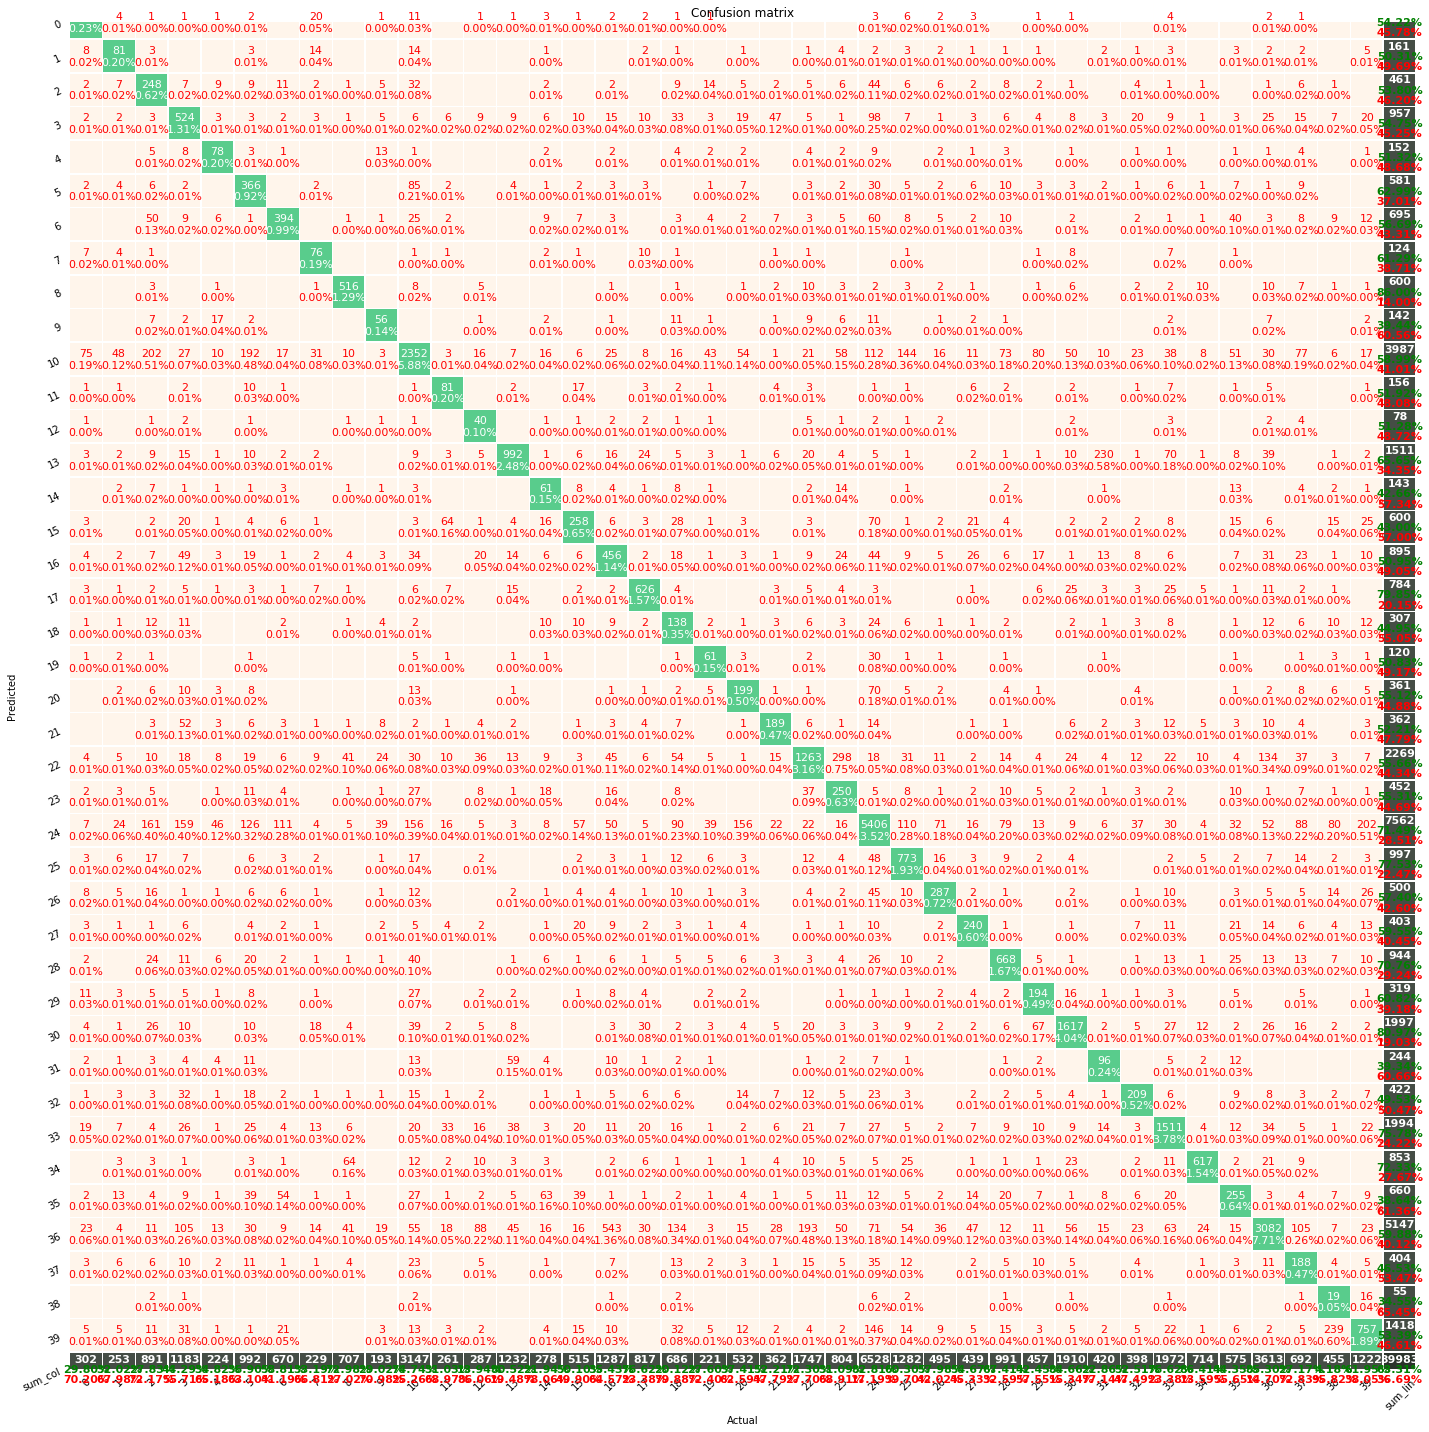

In [151]:
pretty_plot_confusion_matrix(cm)